### Estimating Home Value

by David Rodriguez 2021/12/13

#### Project Goal

The goal of this project is to predict home values as accurately as possible based on a zillow dataset of home listings from 2017.

#### Project Description

Home value appraisals are a big factor in deciding which home to live in. A property's assessed tax value can be contested, but generally falls in a range that ultimately can be somewhat close to what is assessed. Those assessed taxes can be a big liability for homeowners and therefore it is an important factor when purchasing a home. Based on data from home listings from 2017, the goal is to form a model to predict home values.

#### Initial Questions

What is a big factor of assessed taxes in homes?

Does location matter?

Is the total square foot of a home relevant at all?

Does the number of bedrooms or bathrooms matter?

#### Data Dictionary

| Variable | Description |                           |
|:-------------------|:--------------------------------|:
| 1. variable name 1 | text text text | 
| 2. variable name 2 | text text text |

#### Project Objectives

- Document code, process (data acquistion, preparation, exploratory data analysis and statistical testing, modeling, and model evaluation), findings, and key takeaways in a Jupyter Notebook Final Report.

- Create modules (acquire.py, prepare.py) that make your process repeateable and your report (notebook) easier to read and follow.

- Ask exploratory questions of your data that will help you understand more about the attributes and drivers of home value. Answer questions through charts and statistical tests.

- Construct a model to predict assessed home value for single family properties using regression techniques.

- Make recommendations to a data science team about how to improve predictions.

- Refine your work into a Report, in the form of a jupyter notebook, that you will walk through in a 5 minute presentation to a group of collegues and managers about the work you did, why, goals, what you found, your methdologies, and your conclusions.

- Be prepared to answer panel questions about your code, process, findings and key takeaways, and model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
import sklearn.preprocessing
import sklearn.linear_model
import sklearn.feature_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression, RFE
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
import env

In [ ]:
# to do
# REMOVE taxamount FROM MODEL ON SECOND RUN THROUGH!!!! :(
    # drop tax rate too :( :( 
        # DONE DONE
# add column for three fips to table? might be helpful to visualize differences and start
# over or add to round 2 
        # DID THAT ON WIP V1
# put together models
        # DID THAT ON WIP V1
# add more takeaways!
        # DEFINITELY WORK ON THIS
# start readme file
        # NEED TO WORK ON THIS
# finally put together deliverable model
# add hypothesis testing for wip v2
# include additional columns from database to see if that helps improve model?

In [445]:
# Acquisition of data
def zillow_data():
    '''
    This function reads the iris data from the Codeup db into a df.
    '''
    sql_query = """
                SELECT bedroomcnt, bathroomcnt, basementsqft, garagetotalsqft,
                calculatedfinishedsquarefeet, poolcnt, numberofstories,
                taxvaluedollarcnt, yearbuilt, fips 
                FROM properties_2017
                JOIN propertylandusetype USING(propertylandusetypeid)
                JOIN predictions_2017 USING(parcelid)
                WHERE propertylandusetype.propertylandusetypeid = 261 AND 279
                AND predictions_2017.transactiondate LIKE '2017%%';
                """
    
    # Read in DataFrame from Codeup db.
    df = pd.read_sql(sql_query, get_connection('zillow'))
    
    return df

def get_connection(db, user = env.user, host = env.host, password = env.password):
    '''
    This function uses my info from my env file to
    create a connection url to access the Codeup db.
    It takes in a string name of a database as an argument.
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

In [491]:
df = zillow_data()
df.head(3)

,bedroomcnt,bathroomcnt,basementsqft,garagetotalsqft,calculatedfinishedsquarefeet,poolcnt,numberofstories,taxvaluedollarcnt,yearbuilt,fips
0,4.0,3.5,NaN,633.0,3100.0,NaN,NaN,1023282.0,1998.0,6059.0
1,2.0,1.0,NaN,0.0,1465.0,NaN,1.0,464000.0,1967.0,6111.0
2,3.0,2.0,NaN,440.0,1243.0,1.0,1.0,564778.0,1962.0,6059.0


In [492]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52441 non-null  float64
 1   bathroomcnt                   52441 non-null  float64
 2   basementsqft                  47 non-null     float64
 3   garagetotalsqft               18015 non-null  float64
 4   calculatedfinishedsquarefeet  52359 non-null  float64
 5   poolcnt                       11096 non-null  float64
 6   numberofstories               14561 non-null  float64
 7   taxvaluedollarcnt             52440 non-null  float64
 8   yearbuilt                     52325 non-null  float64
 9   fips                          52441 non-null  float64
dtypes: float64(10)
memory usage: 4.0 MB


In [485]:
df.isnull().sum()

bedroomcnt                          0
bathroomcnt                         0
basementsqft                    52394
garagetotalsqft                 34426
calculatedfinishedsquarefeet       82
poolcnt                         41345
numberofstories                 37880
taxvaluedollarcnt                   1
yearbuilt                         116
fips                                0
dtype: int64

In [ ]:
# takaways
    # will definitely need to impute values on addition square feet such as pool, garage,
    # yard, etc. to zero
    # fireplacecnt and garagecnt, hashottub, poolcnt, number of stories missing values 
    # will be changed to 0

In [486]:
def wrangle_zillow(df):
    '''
       This function replaces blank spaces with nan values, then those values are dropped. Finally,              outliers and properties with 0
       bathrooms and less than 200 square feet are dropped.
    '''
    
    # replace blank spaces with nan's
    df = df.replace(r'^\s*$', np.nan, regex=True)
    
    # replace nan's with zero on columns that make sense to have 0 square feet or 0 count
    df['basementsqft'] = df['basementsqft'].fillna(0)
    df['garagetotalsqft'] = df['garagetotalsqft'].fillna(0)
    df['poolcnt'] = df['poolcnt'].fillna(0)
    
    # replace nan's on number of stories column with 1
    df['numberofstories'] = df['numberofstories'].fillna(1)
    
    # combine sqrft columns into one and drop unneeded columns
    df['comb_sq_ft'] = df['basementsqft'] + df['garagetotalsqft'] + df['calculatedfinishedsquarefeet']
    df.drop(columns = ['basementsqft', 'garagetotalsqft', 'calculatedfinishedsquarefeet'], inplace = True)
    
    # drop nan's
    df = df.dropna()
    
    # remove outliers
    z_scores = stats.zscore(df)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 3).all(axis = 1)
    df = df[filtered_entries]
   
    # removing single family houses with no bathrooms
    # 121 values
    df = df[df['bathroomcnt'] != 0]
    
    # removing single family houses with less than 200 sqared feet
    # 2 values
    df = df[df['comb_sq_ft'] > 200]
    
    # rename columns
    df = df.rename(columns = {'bedroomcnt': 'bedroom_cnt', 'bathroomcnt': 'bathroom_cnt', 'taxvaluedollarcnt': 'assessed_tax_value', 'yearbuilt': 'year_built', 'poolcnt': 'pool_cnt', 'numberofstories': 'nbr_stories'})
    
    # map fips codes to locations
    df['location'] = df['fips']
    df['location'] = df['location'].map({6037.0: 'Los Angeles, CA', 6059.0: 'Orange, CA', 6111.0: 'Ventura, CA'})
    
    return df

In [493]:
df = wrangle_zillow(df)

In [482]:
#df.drop(columns = 'location', inplace = True)
z_scores = stats.zscore(df)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis = 1)
#df = df[filtered_entries]
df[filtered_entries]

,bedroom_cnt,bathroom_cnt,pool_cnt,nbr_stories,assessed_tax_value,year_built,comb_sq_ft


In [494]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50370 entries, 0 to 52440
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bedroom_cnt         50370 non-null  float64
 1   bathroom_cnt        50370 non-null  float64
 2   pool_cnt            50370 non-null  float64
 3   nbr_stories         50370 non-null  float64
 4   assessed_tax_value  50370 non-null  float64
 5   year_built          50370 non-null  float64
 6   fips                50370 non-null  float64
 7   comb_sq_ft          50370 non-null  float64
 8   location            50370 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.8+ MB


In [495]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
bedroom_cnt,50370.0,3.262577,0.880625,1.0,3.0,3.0,4.0,6.0
bathroom_cnt,50370.0,2.217094,0.862244,1.0,2.0,2.0,3.0,5.0
pool_cnt,50370.0,0.199067,0.399302,0.0,0.0,0.0,0.0,1.0
nbr_stories,50370.0,1.101529,0.302031,1.0,1.0,1.0,1.0,2.0
assessed_tax_value,50370.0,453296.662200,387474.506812,1000.0,188466.0,363201.5,588779.0,2764876.0
year_built,50370.0,1962.882569,22.722611,1894.0,1950.0,1960.0,1978.0,2016.0
fips,50370.0,6048.923963,20.971179,6037.0,6037.0,6037.0,6059.0,6111.0
comb_sq_ft,50370.0,1988.986897,873.466443,300.0,1339.0,1800.0,2460.0,5395.0


In [496]:
df.head()

,bedroom_cnt,bathroom_cnt,pool_cnt,nbr_stories,assessed_tax_value,year_built,fips,comb_sq_ft,location
0,4.0,3.5,0.0,1.0,1023282.0,1998.0,6059.0,3733.0,"Orange, CA"
1,2.0,1.0,0.0,1.0,464000.0,1967.0,6111.0,1465.0,"Ventura, CA"
2,3.0,2.0,1.0,1.0,564778.0,1962.0,6059.0,1683.0,"Orange, CA"
3,4.0,3.0,1.0,1.0,145143.0,1970.0,6037.0,2376.0,"Los Angeles, CA"
4,4.0,3.0,1.0,1.0,773303.0,1950.0,6037.0,2962.0,"Los Angeles, CA"


In [295]:
num_cols = df.select_dtypes(exclude = 'object')
num_cols

,bedroom_cnt,bathroom_cnt,calculatedfinishedsquarefeet,poolcnt,numberofstories,lotsizesquarefeet,assessed_tax_value,year_built,fips,comb_sq_ft
0,4.0,3.5,3100.0,0.0,1.0,4506.0,1023282.0,1998.0,6059.0,3733.0
1,2.0,1.0,1465.0,0.0,1.0,12647.0,464000.0,1967.0,6111.0,1465.0
2,3.0,2.0,1243.0,1.0,1.0,8432.0,564778.0,1962.0,6059.0,1683.0
3,4.0,3.0,2376.0,1.0,1.0,13038.0,145143.0,1970.0,6037.0,2376.0
4,4.0,3.0,2962.0,1.0,1.0,63000.0,773303.0,1950.0,6037.0,2962.0
...,...,...,...,...,...,...,...,...,...,...
52436,4.0,2.0,1633.0,0.0,1.0,4630.0,346534.0,1962.0,6037.0,1633.0
52437,2.0,2.0,1286.0,0.0,1.0,47405.0,354621.0,1940.0,6037.0,1286.0
52438,4.0,2.0,1612.0,0.0,1.0,12105.0,67205.0,1964.0,6111.0,2172.0
52439,3.0,1.0,1032.0,0.0,1.0,5074.0,49546.0,1954.0,6037.0,1032.0


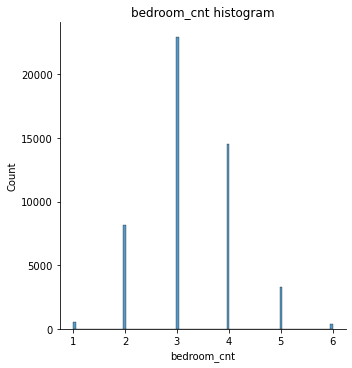

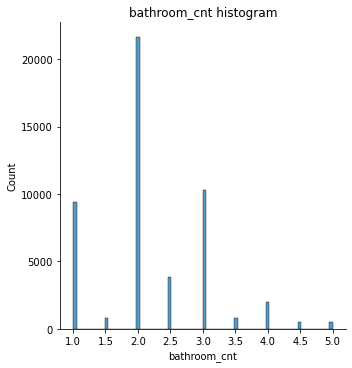

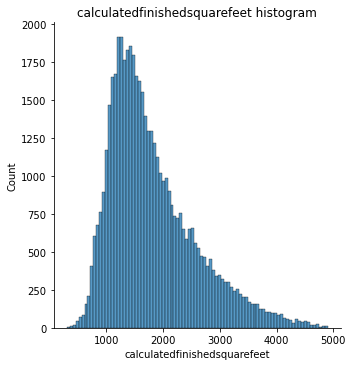

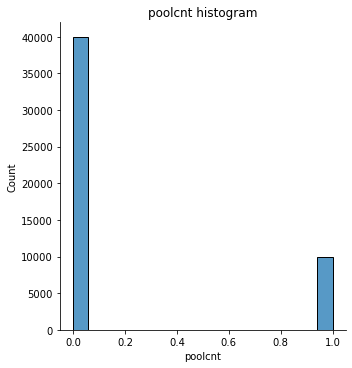

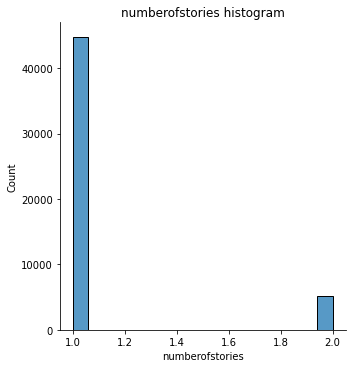

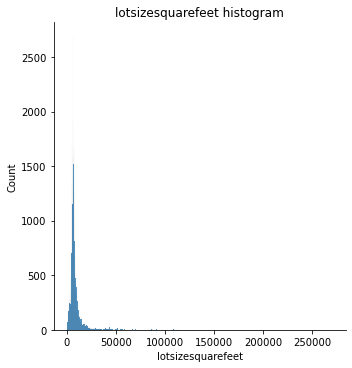

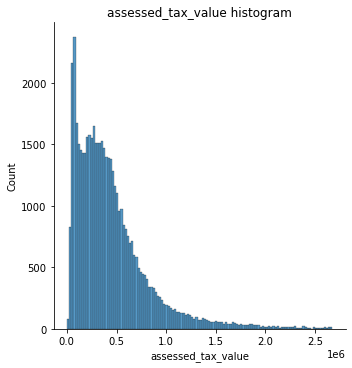

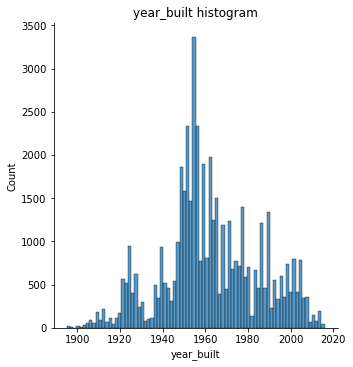

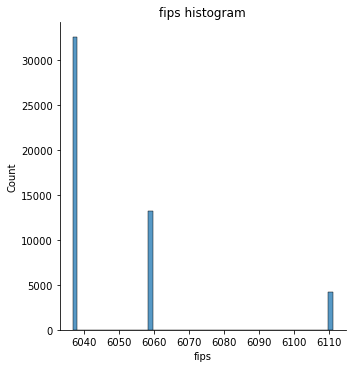

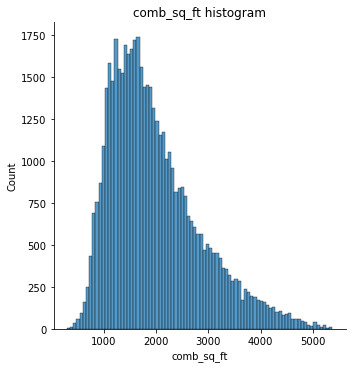

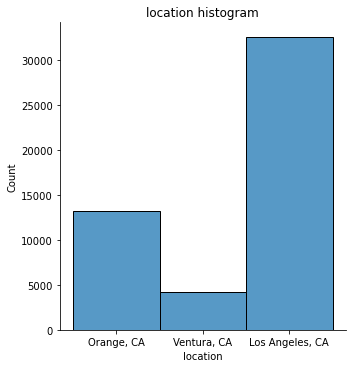

In [296]:
# univariate visualizations
for col in df:
    sns.displot(x = col, data = df)
    plt.title(col + ' histogram')
    plt.show()

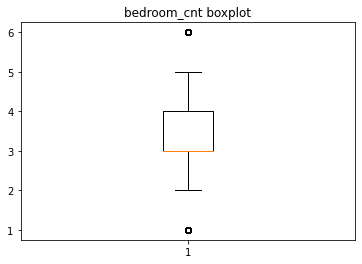

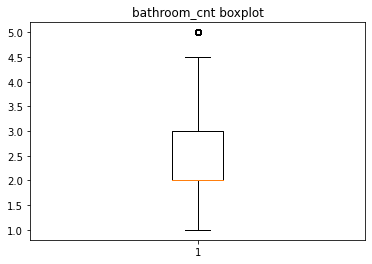

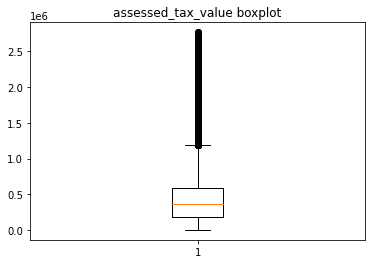

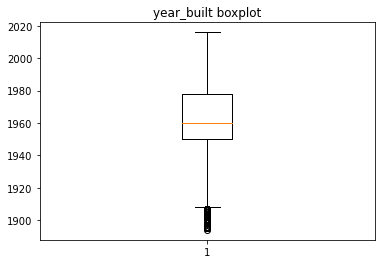

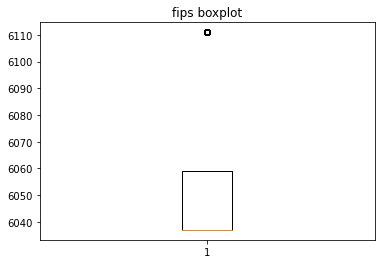

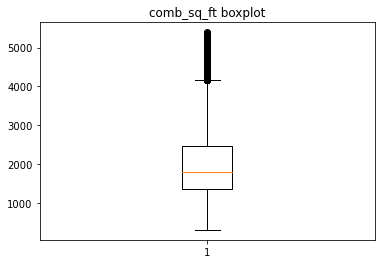

In [248]:
for col in num_cols:
    plt.title(col + ' boxplot')
    plt.boxplot(df[col], meanline = True)
    plt.show();    

In [297]:
encoded_df = pd.get_dummies(df['location'], drop_first = False)
concat_df = df.drop(columns = ['location'])
concat_df = pd.concat([concat_df, encoded_df], axis = 1)
concat_df.head()

,bedroom_cnt,bathroom_cnt,calculatedfinishedsquarefeet,poolcnt,numberofstories,lotsizesquarefeet,assessed_tax_value,year_built,fips,comb_sq_ft,"Los Angeles, CA","Orange, CA","Ventura, CA"
0,4.0,3.5,3100.0,0.0,1.0,4506.0,1023282.0,1998.0,6059.0,3733.0,0,1,0
1,2.0,1.0,1465.0,0.0,1.0,12647.0,464000.0,1967.0,6111.0,1465.0,0,0,1
2,3.0,2.0,1243.0,1.0,1.0,8432.0,564778.0,1962.0,6059.0,1683.0,0,1,0
3,4.0,3.0,2376.0,1.0,1.0,13038.0,145143.0,1970.0,6037.0,2376.0,1,0,0
4,4.0,3.0,2962.0,1.0,1.0,63000.0,773303.0,1950.0,6037.0,2962.0,1,0,0


In [298]:
encoded_df

,"Los Angeles, CA","Orange, CA","Ventura, CA"
0,0,1,0
1,0,0,1
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
52436,1,0,0
52437,1,0,0
52438,0,0,1
52439,1,0,0


In [416]:
# Exploration
train_and_validate, test = train_test_split(concat_df, random_state = 123)
train, validate = train_test_split(train_and_validate)
test.shape, train.shape, validate.shape

((12468, 13), (28050, 13), (9351, 13))

In [300]:
train_num_cols = df.select_dtypes(exclude = 'object')

In [301]:
train_num_cols

,bedroom_cnt,bathroom_cnt,calculatedfinishedsquarefeet,poolcnt,numberofstories,lotsizesquarefeet,assessed_tax_value,year_built,fips,comb_sq_ft
0,4.0,3.5,3100.0,0.0,1.0,4506.0,1023282.0,1998.0,6059.0,3733.0
1,2.0,1.0,1465.0,0.0,1.0,12647.0,464000.0,1967.0,6111.0,1465.0
2,3.0,2.0,1243.0,1.0,1.0,8432.0,564778.0,1962.0,6059.0,1683.0
3,4.0,3.0,2376.0,1.0,1.0,13038.0,145143.0,1970.0,6037.0,2376.0
4,4.0,3.0,2962.0,1.0,1.0,63000.0,773303.0,1950.0,6037.0,2962.0
...,...,...,...,...,...,...,...,...,...,...
52436,4.0,2.0,1633.0,0.0,1.0,4630.0,346534.0,1962.0,6037.0,1633.0
52437,2.0,2.0,1286.0,0.0,1.0,47405.0,354621.0,1940.0,6037.0,1286.0
52438,4.0,2.0,1612.0,0.0,1.0,12105.0,67205.0,1964.0,6111.0,2172.0
52439,3.0,1.0,1032.0,0.0,1.0,5074.0,49546.0,1954.0,6037.0,1032.0


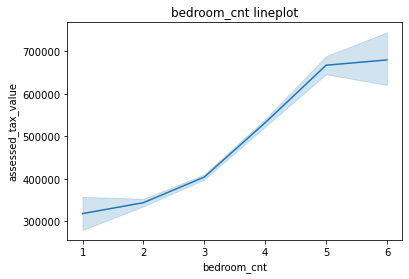

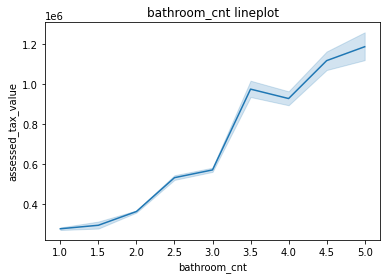

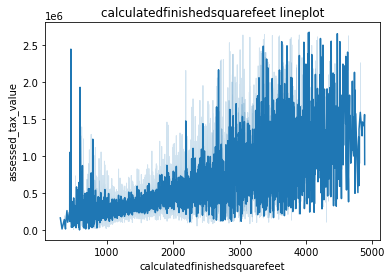

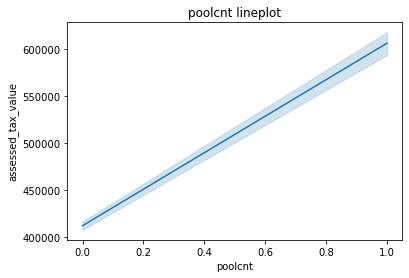

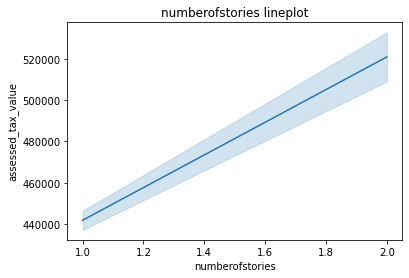

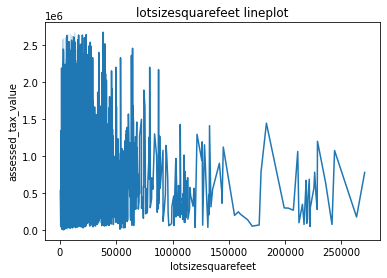

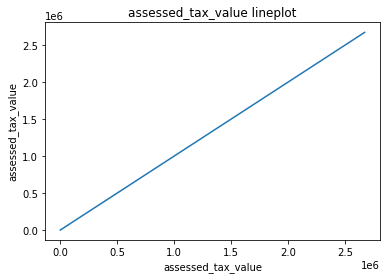

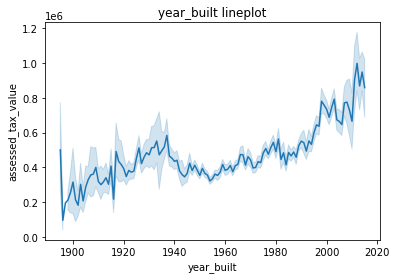

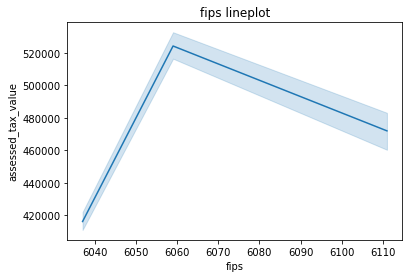

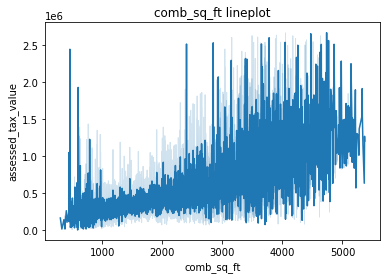

In [302]:
# bivariate visualizations
for col in train_num_cols:
    sns.lineplot(x = col, y = train['assessed_tax_value'], data = train)
    plt.title(col + ' lineplot')
    plt.show()

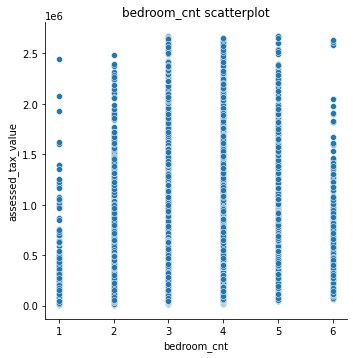

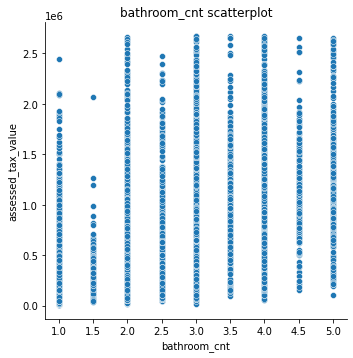

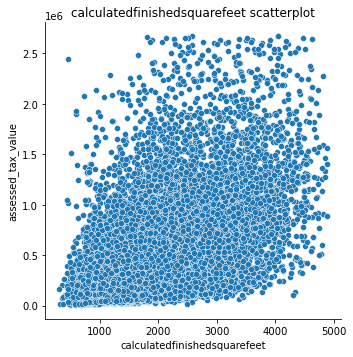

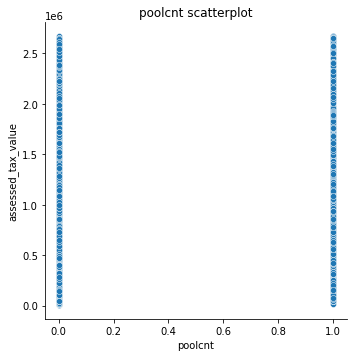

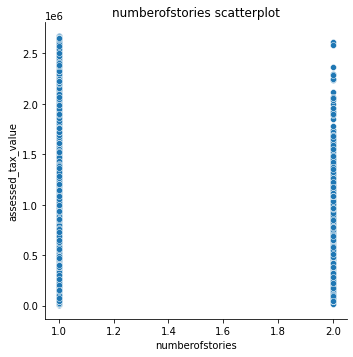

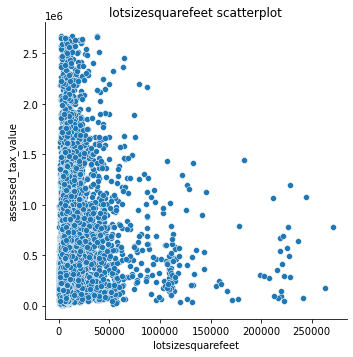

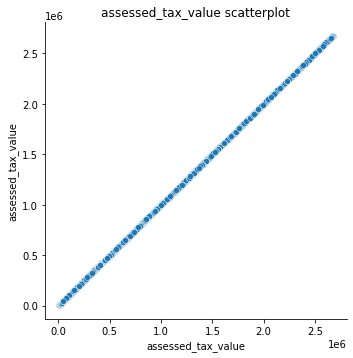

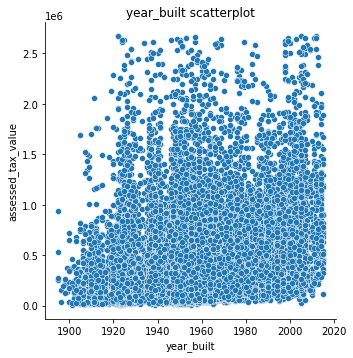

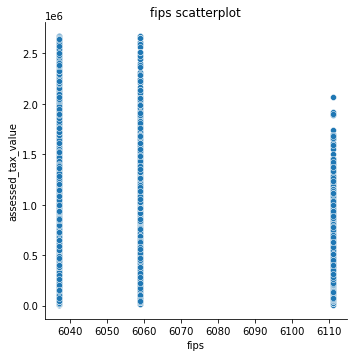

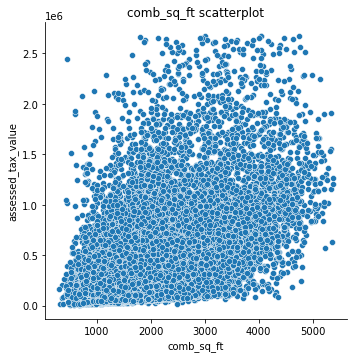

In [303]:
for col in train_num_cols:
    sns.relplot(x = col, y = train['assessed_tax_value'], data = train, kind = 'scatter')
    plt.title(col + ' scatterplot')
    plt.show()

<AxesSubplot:>

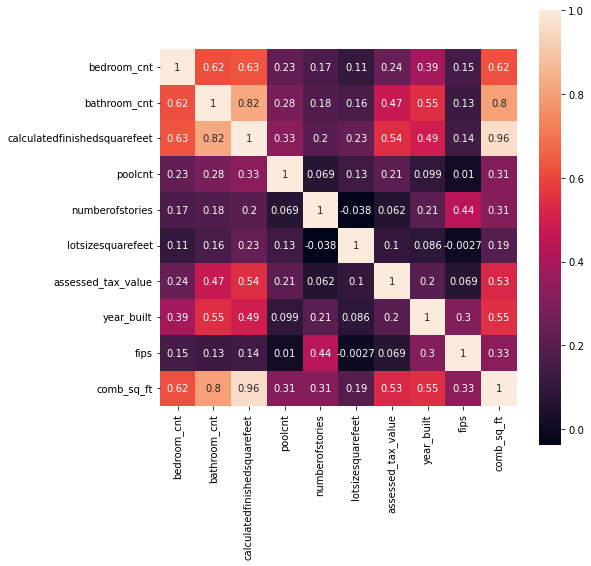

In [304]:
plt.figure(figsize = (8,8))
sns.heatmap(train_num_cols.corr(), square = True, annot = True)

<AxesSubplot:>

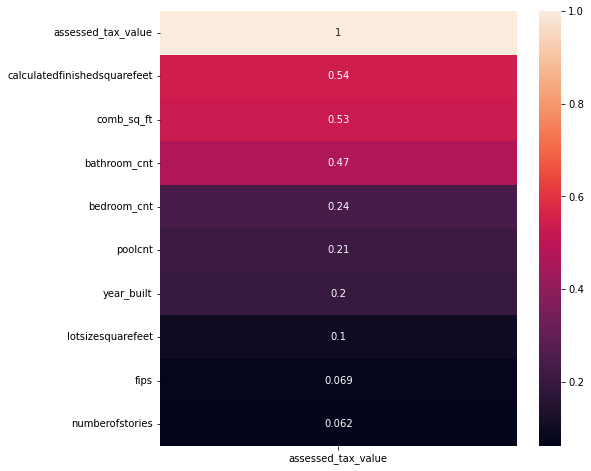

In [305]:
plt.figure(figsize = (8,8))
sns.heatmap(train_num_cols.corr()[['assessed_tax_value']].sort_values(by = 'assessed_tax_value', ascending = False), annot = True)

In [89]:
df = zillow_data()

In [82]:
    # replace blank spaces with nan's
    df = df.replace(r'^\s*$', np.nan, regex=True)
    
    # replace nan's with zero on columns that make sense to have 0 square feet or 0 count
    df['basementsqft'] = df['basementsqft'].fillna(0)
    df['garagetotalsqft'] = df['garagetotalsqft'].fillna(0)
    df['poolsizesum'] = df['poolsizesum'].fillna(0)
    df['yardbuildingsqft17'] = df['yardbuildingsqft17'].fillna(0)
    df['yardbuildingsqft26'] = df['yardbuildingsqft26'].fillna(0)
    df['fireplacecnt'] = df['fireplacecnt'].fillna(0)
    df['garagecarcnt'] = df['garagecarcnt'].fillna(0)
    df['poolcnt'] = df['poolcnt'].fillna(0)
    
    #replace nan's on number of stories column with 1
    df['numberofstories'] = df['numberofstories'].fillna(1)

<AxesSubplot:>

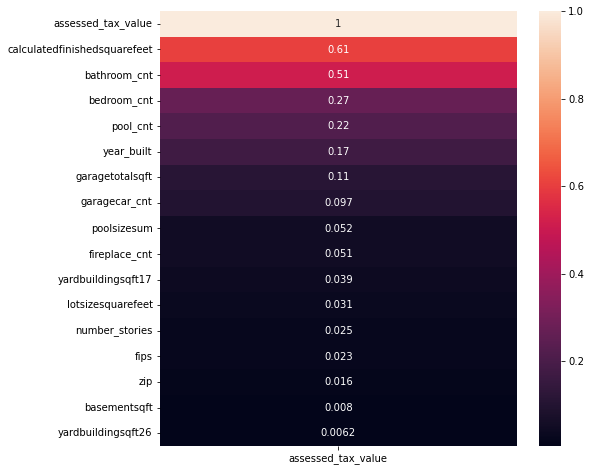

In [86]:
plt.figure(figsize = (8,8))
sns.heatmap(df.corr()[['assessed_tax_value']].sort_values(by = 'assessed_tax_value', ascending = False), annot = True)

In [85]:
 # rename columns

df = df.rename(columns = {'bedroomcnt': 'bedroom_cnt', 'bathroomcnt': 'bathroom_cnt', 'fireplacecnt': 'fireplace_cnt', 'garagecarcnt': 'garagecar_cnt', 'poolcnt': 'pool_cnt', 'regionidzip': 'zip', 'numberofstories': 'number_stories', 'taxvaluedollarcnt': 'assessed_tax_value', 'yearbuilt': 'year_built'})
    

In [90]:
df = wrangle_zillow(df)

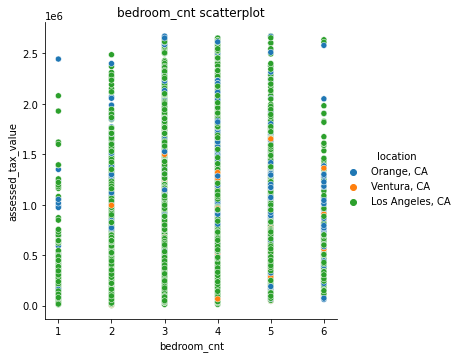

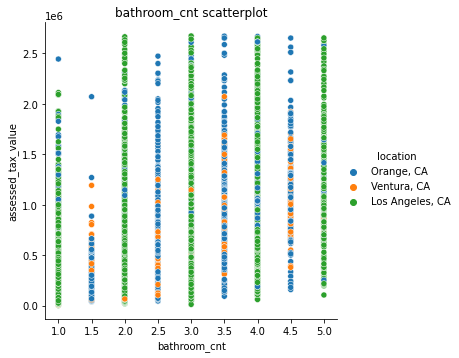

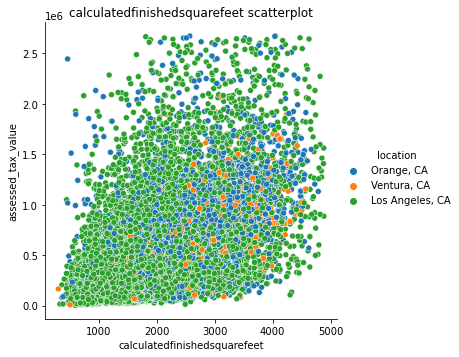

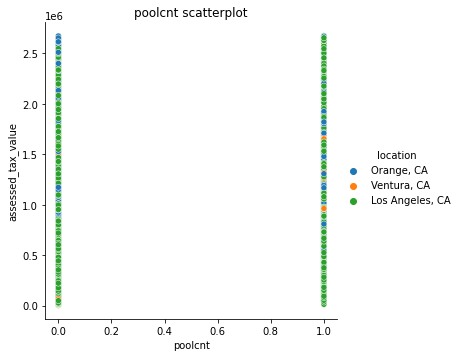

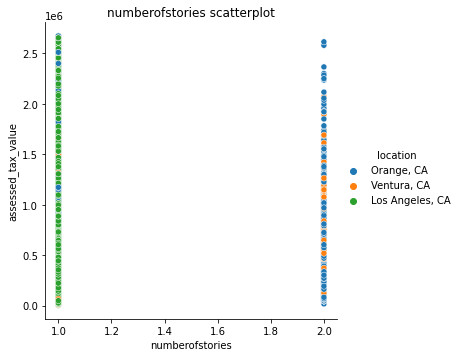

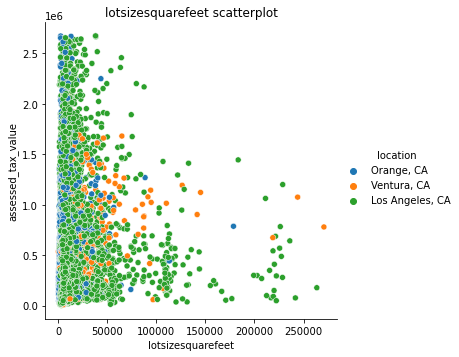

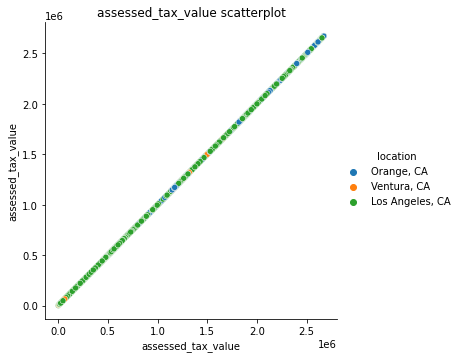

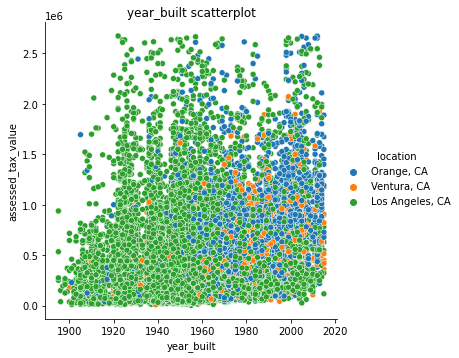

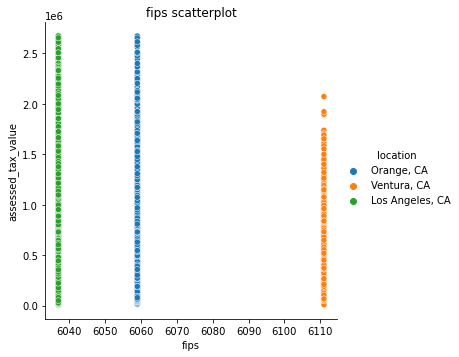

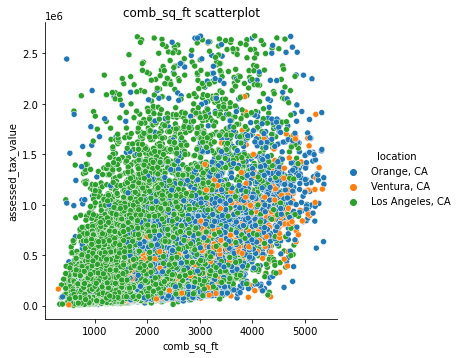

In [306]:
# multivariate visualizations

for col in train_num_cols:
    sns.relplot(x = col, y = train['assessed_tax_value'], data = df, kind = 'scatter', hue = 'location')
    plt.title(col + ' scatterplot')
    plt.show()

In [307]:
# modeling
# baseline
baseline = df
baseline['pred_mean'] = baseline.assessed_tax_value.mean()
baseline['pred_median'] = baseline.assessed_tax_value.median()
baseline.head()

,bedroom_cnt,bathroom_cnt,calculatedfinishedsquarefeet,poolcnt,numberofstories,lotsizesquarefeet,assessed_tax_value,year_built,fips,comb_sq_ft,location,pred_mean,pred_median
0,4.0,3.5,3100.0,0.0,1.0,4506.0,1023282.0,1998.0,6059.0,3733.0,"Orange, CA",449986.036556,362433.0
1,2.0,1.0,1465.0,0.0,1.0,12647.0,464000.0,1967.0,6111.0,1465.0,"Ventura, CA",449986.036556,362433.0
2,3.0,2.0,1243.0,1.0,1.0,8432.0,564778.0,1962.0,6059.0,1683.0,"Orange, CA",449986.036556,362433.0
3,4.0,3.0,2376.0,1.0,1.0,13038.0,145143.0,1970.0,6037.0,2376.0,"Los Angeles, CA",449986.036556,362433.0
4,4.0,3.0,2962.0,1.0,1.0,63000.0,773303.0,1950.0,6037.0,2962.0,"Los Angeles, CA",449986.036556,362433.0


In [308]:
b_train_and_validate, b_test = train_test_split(baseline, random_state = 123)
b_train, b_validate = train_test_split(b_train_and_validate)

In [309]:
target = "assessed_tax_value"

# split train into X (dataframe, drop target) & y (series, keep target only)
b_X_train = b_train.drop(columns = [target])
b_y_train = b_train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
b_X_validate = b_validate.drop(columns = [target])
b_y_validate = b_validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
b_X_test = b_test.drop(columns = [target])
b_y_test = b_test[target]

b_y_train

23458    1242640.0
48750     530000.0
21283    1090401.0
47577     496874.0
43076     291334.0
           ...    
14178     404314.0
29773     317004.0
24342     209487.0
23051    2444554.0
32833     143267.0
Name: assessed_tax_value, Length: 28050, dtype: float64

In [310]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
b_y_train = pd.DataFrame(b_y_train)
b_y_validate = pd.DataFrame(b_y_validate)

# 1. Predict G3_pred_mean
b_pred_mean = b_y_train['assessed_tax_value'].mean()
b_y_train['pred_mean'] = b_pred_mean
b_y_validate['pred_mean'] = b_pred_mean

# 2. compute G3_pred_median
b_pred_median = b_y_train['assessed_tax_value'].median()
b_y_train['pred_median'] = b_pred_median
b_y_validate['pred_median'] = b_pred_median

# 3. RMSE of G3_pred_mean
rmse_train = mean_squared_error(b_y_train.assessed_tax_value, b_y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(b_y_validate.assessed_tax_value, b_y_validate.pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of G3_pred_median
rmse_train = mean_squared_error(b_y_train.assessed_tax_value, b_y_train.pred_median)**(1/2)
rmse_validate = mean_squared_error(b_y_validate.assessed_tax_value, b_y_validate.pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  379969.26 
Validate/Out-of-Sample:  377992.55
RMSE using Median
Train/In-Sample:  390046.95 
Validate/Out-of-Sample:  387239.37


In [311]:
# feature selection

target = 'assessed_tax_value'

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train = train.drop(columns = [target])
y_train = train[target]

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate = validate.drop(columns = [target])
y_validate = validate[target]

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test = test.drop(columns = [target])
y_test = test[target]

X_train.head()

,bedroom_cnt,bathroom_cnt,calculatedfinishedsquarefeet,poolcnt,numberofstories,lotsizesquarefeet,year_built,fips,comb_sq_ft,"Los Angeles, CA","Orange, CA","Ventura, CA"
18094,3.0,2.5,2167.0,0.0,2.0,5555.0,1999.0,6111.0,2799.0,0,0,1
22553,3.0,2.0,1824.0,0.0,1.0,29457.0,1988.0,6037.0,1824.0,1,0,0
17997,3.0,2.5,2466.0,0.0,1.0,22375.0,1988.0,6111.0,3206.0,0,0,1
36239,3.0,3.0,1804.0,1.0,1.0,7028.0,1952.0,6037.0,1804.0,1,0,0
40498,3.0,2.0,1216.0,0.0,1.0,3920.0,1924.0,6037.0,1216.0,1,0,0


In [409]:
def standard_scaler_tvt(train, validate, test):
    # list of columns float and int dtypes
    num_cols = list(train.select_dtypes(include = ['float64', 'int64', 'complex']).columns)
    
    # standard scaler object
    scaler = sklearn.preprocessing.StandardScaler()
    
    # fit scaler
    scaler.fit(train[num_cols])
    
    # scale
    train_scaled = scaler.transform(train[num_cols])
    validate_scaled = scaler.transform(validate[num_cols])
    test_scaled = scaler.transform(test[num_cols])

    # new column names
    new_column_names = [c + '_scaled' for c in num_cols]

    # add scaled columns to input dataset
    train[new_column_names] = scaler.transform(train[num_cols])
    validate[new_column_names] = scaler.transform(validate[num_cols])
    test[new_column_names] = scaler.transform(test[num_cols])
    
    # transform series to DF
    train = pd.DataFrame(train, columns = num_cols)
    validate = pd.DataFrame(validate, columns = num_cols)
    test = pd.DataFrame(test, columns = num_cols)
    
    # add column names if scaled df is needed separately
    #train_scaled = pd.DataFrame(train_scaled, columns = num_cols)
    #validate_scaled = pd.DataFrame(validate_scaled, columns = num_cols)
    #test_scaled = pd.DataFrame(test_scaled, columns = num_cols)
    
    return train, validate, test

In [417]:
train.shape, validate.shape, test.shape

((28050, 13), (9351, 13), (12468, 13))

In [426]:
train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28050 entries, 51865 to 50565
Data columns (total 20 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   bedroom_cnt                          28050 non-null  float64
 1   bathroom_cnt                         28050 non-null  float64
 2   calculatedfinishedsquarefeet         28050 non-null  float64
 3   poolcnt                              28050 non-null  float64
 4   numberofstories                      28050 non-null  float64
 5   lotsizesquarefeet                    28050 non-null  float64
 6   assessed_tax_value                   28050 non-null  float64
 7   year_built                           28050 non-null  float64
 8   fips                                 28050 non-null  float64
 9   comb_sq_ft                           28050 non-null  float64
 10  bedroom_cnt_scaled                   28050 non-null  float64
 11  bathroom_cnt_scaled     

In [425]:
train_scaled, validate_scaled, test_scaled = standard_scaler_tvt(train, validate, test)

In [422]:
train_scaled.shape

(28050, 10)

In [429]:
target = ['assessed_tax_value', 'assessed_tax_value_scaled']

# split train into X (dataframe, drop target) & y (series, keep target only)
X_train_scaled = train_scaled.drop(columns = ['assessed_tax_value', 'assessed_tax_value_scaled'])
y_train_scaled = train_scaled.assessed_tax_value

# split validate into X (dataframe, drop target) & y (series, keep target only)
X_validate_scaled = validate_scaled.drop(columns = ['assessed_tax_value', 'assessed_tax_value_scaled'])
y_validate_scaled = validate_scaled.assessed_tax_value

# split test into X (dataframe, drop target) & y (series, keep target only)
X_test_scaled = test_scaled.drop(columns = ['assessed_tax_value', 'assessed_tax_value_scaled'])
y_test_scaled = test_scaled.assessed_tax_value

X_train_scaled.head()

,bedroom_cnt,bathroom_cnt,calculatedfinishedsquarefeet,poolcnt,numberofstories,lotsizesquarefeet,year_built,fips,comb_sq_ft,bedroom_cnt_scaled,bathroom_cnt_scaled,calculatedfinishedsquarefeet_scaled,poolcnt_scaled,numberofstories_scaled,lotsizesquarefeet_scaled,year_built_scaled,fips_scaled,comb_sq_ft_scaled
51865,4.0,3.0,4876.0,1.0,1.0,18391.0,1986.0,6037.0,4876.0,0.851002,0.924696,4.014212,2.021646,-0.338786,0.858104,1.033608,-0.571504,3.351428
40692,3.0,2.0,1307.0,0.0,1.0,6510.0,1993.0,6037.0,1307.0,-0.295135,-0.244592,-0.668230,-0.494647,-0.338786,-0.202381,1.344101,-0.571504,-0.780565
20213,3.0,1.0,1080.0,0.0,1.0,5263.0,1953.0,6037.0,1080.0,-0.295135,-1.413879,-0.966049,-0.494647,-0.338786,-0.313686,-0.430148,-0.571504,-1.043374
42523,3.0,2.0,1110.0,0.0,1.0,9926.0,1962.0,6037.0,1110.0,-0.295135,-0.244592,-0.926690,-0.494647,-0.338786,0.102528,-0.030942,-0.571504,-1.008641
22792,2.0,1.5,864.0,0.0,2.0,640.0,1963.0,6059.0,864.0,-1.441272,-0.829235,-1.249436,-0.494647,2.951712,-0.726330,0.013414,0.478975,-1.293447


In [430]:
lrm = LinearRegression()
rfe = RFE(lrm, n_features_to_select = 4)

rfe.fit(X_train_scaled, y_train_scaled)

rfe_columns = X_train_scaled.columns[rfe.support_].tolist()
print('The best six features are: ', rfe_columns)

The best six features are:  ['bedroom_cnt', 'bathroom_cnt', 'bedroom_cnt_scaled', 'bathroom_cnt_scaled']


In [431]:
def show_features_rankings(X_train, rfe):
    """
    Takes in a dataframe and a fit RFE object in order to output the rank of all features
    """
    # rfe here is reference rfe from cell 15
    var_ranks = rfe.ranking_
    var_names = X_train.columns.tolist()
    ranks = pd.DataFrame({'Var': var_names, 'Rank': var_ranks})
    ranks = ranks.sort_values(by = "Rank", ascending = True)
    return ranks

In [432]:
show_features_rankings(X_train_scaled, rfe)

,Var,Rank
0,bedroom_cnt,1
1,bathroom_cnt,1
10,bathroom_cnt_scaled,1
9,bedroom_cnt_scaled,1
3,poolcnt,2
12,poolcnt_scaled,3
4,numberofstories,4
13,numberofstories_scaled,5
6,year_built,6
7,fips,7


In [220]:
#X_train_scaled = X_train_scaled.drop(columns = ['garagecar_cnt', 'fireplace_cnt', 'year_built', 'fips'])
#X_validate_scaled = X_validate_scaled.drop(columns = ['garagecar_cnt', 'fireplace_cnt', 'year_built', 'fips'])
#X_test_scaled = X_test_scaled.drop(columns = ['garagecar_cnt', 'fireplace_cnt', 'year_built', 'fips'])

In [345]:
X_train_scaled = X_train_scaled.drop(columns = ['numberofstories', 'year_built', 'comb_sq_ft'])
X_validate_scaled = X_validate_scaled.drop(columns = ['numberofstories', 'year_built', 'comb_sq_ft'])
X_test_scaled = X_test_scaled.drop(columns = ['numberofstories', 'year_built', 'comb_sq_ft'])

In [346]:
X_train_scaled

,bedroom_cnt,bathroom_cnt,calculatedfinishedsquarefeet
0,-0.296380,0.343070,0.458157
1,-0.296380,-0.244924,0.007910
2,-0.296380,0.343070,0.850647
3,-0.296380,0.931063,-0.018343
4,-0.296380,-0.244924,-0.790195
...,...,...,...
28045,1.993515,0.931063,0.358394
28046,-0.296380,-0.244924,-0.280878
28047,-0.296380,0.343070,0.068293
28048,-0.296380,-0.832918,-0.711435


In [337]:
y_train_scaled = pd.DataFrame(y_train_scaled)
y_validate_scaled = pd.DataFrame(y_validate_scaled)
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

In [433]:
# OLS
ols = LinearRegression(normalize = True)

ols.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_ols'] = ols.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_ols)**(1/2)

# predict validate
y_validate['pred_ols'] = ols.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_ols)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  379302.3546616082 
Validation/Out-of-Sample:  380156.8237307588


In [434]:
# lassolars

lasso = LassoLars(alpha = 1.0)

lasso.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_lasso'] = lasso.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_lasso)**(1/2)

y_validate['pred_lasso'] = lasso.predict(X_validate_scaled)

rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_lasso)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  379264.9728104873 
Validation/Out-of-Sample:  380077.3405157929


In [349]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 0, alpha = 0)

glm.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  313340.6843072377 
Validation/Out-of-Sample:  314451.4031336579


In [435]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 1, alpha = 0)

glm.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  379284.95191307034 
Validation/Out-of-Sample:  380043.6768446756


In [351]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 2, alpha = 0)

glm.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  315026.359042584 
Validation/Out-of-Sample:  316309.4236459341


In [436]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 3, alpha = 0)

glm.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  379284.95191307034 
Validation/Out-of-Sample:  380043.6768446756


In [437]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 1, alpha = 1.0)

glm.fit(X_train_scaled, y_train.assessed_tax_value)

y_train['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_glm)**(1/2)

# predict validate
y_validate['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  379284.95191307034 
Validation/Out-of-Sample:  380043.6768446756


In [438]:
# polynomial

pf = PolynomialFeatures(degree = 2)

X_train_degree2 = pf.fit_transform(X_train_scaled)

X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [439]:
lm2 = LinearRegression(normalize = True)

lm2.fit(X_train_degree2, y_train.assessed_tax_value)

y_train['pred_lm2'] = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train.assessed_tax_value, y_train.pred_lm2)**(1/2)

y_validate['pred_lm2'] = lm2.predict(X_validate_degree2)

rmse_validate = mean_squared_error(y_validate.assessed_tax_value, y_validate.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  379354.249984181 
Validation/Out-of-Sample:  380577.9056182072


In [ ]:
# models aren't performing that great with additional features added...
# need to check how to improve linear regression performance

In [379]:
y_train_scaled

,assessed_tax_value
0,-0.011458
1,-0.892378
2,0.721166
3,-0.520444
4,0.184182
...,...
28045,-0.658190
28046,0.065972
28047,-0.447863
28048,-1.064610


In [380]:
# OLS
ols = LinearRegression(normalize = True)

ols.fit(X_train_scaled, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_ols'] = ols.predict(X_train_scaled)

# evaluate: rmse
rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_ols)**(1/2)

# predict validate
y_validate_scaled['pred_ols'] = ols.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_ols)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  0.8261352914920108 
Validation/Out-of-Sample:  0.8290637462293546


In [381]:
# lassolars

lasso = LassoLars(alpha = 1.0)

lasso.fit(X_train_scaled, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_lasso'] = lasso.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_lasso)**(1/2)

y_validate_scaled['pred_lasso'] = lasso.predict(X_validate_scaled)

rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_lasso)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  1.0 
Validation/Out-of-Sample:  1.0020004087369625


In [382]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 0, alpha = 0)

glm.fit(X_train_scaled, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_glm)**(1/2)

# predict validate
y_validate_scaled['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  0.8261352922623225 
Validation/Out-of-Sample:  0.8290633186871958


In [384]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 1, alpha = 0.01)

glm.fit(X_train_scaled, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_glm)**(1/2)

# predict validate
y_validate_scaled['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

In [386]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 2, alpha = 0)

glm.fit(X_train_scaled, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_glm)**(1/2)

# predict validate
y_validate_scaled['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

In [387]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 3, alpha = 0)

glm.fit(X_train_scaled, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_glm)**(1/2)

# predict validate
y_validate_scaled['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

In [388]:
# TweedieRegressor (GLM)

glm = TweedieRegressor(power = 1, alpha = 1.0)

glm.fit(X_train_scaled, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_glm'] = glm.predict(X_train_scaled)

rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_glm)**(1/2)

# predict validate
y_validate_scaled['pred_glm'] = glm.predict(X_validate_scaled)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

ValueError: Some value(s) of y are out of the valid range for family TweedieDistribution

In [389]:
# polynomial

pf = PolynomialFeatures(degree = 2)

X_train_degree2 = pf.fit_transform(X_train_scaled)

X_validate_degree2 = pf.transform(X_validate_scaled)
X_test_degree2 = pf.transform(X_test_scaled)

In [390]:
lm2 = LinearRegression(normalize = True)

lm2.fit(X_train_degree2, y_train_scaled.assessed_tax_value)

y_train_scaled['pred_lm2'] = lm2.predict(X_train_degree2)

rmse_train = mean_squared_error(y_train_scaled.assessed_tax_value, y_train_scaled.pred_lm2)**(1/2)

y_validate_scaled['pred_lm2'] = lm2.predict(X_validate_degree2)

rmse_validate = mean_squared_error(y_validate_scaled.assessed_tax_value, y_validate_scaled.pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  0.8204370907942399 
Validation/Out-of-Sample:  0.8241941135422036
